# emsemble model

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from data import AntiFraudData
from gradientDescent import *
from confusionMetrics import *
import matplotlib.pyplot as plt
from featureProcess import *
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from random import shuffle
from sklearn.model_selection import GridSearchCV

# feature engineering

In [3]:
folderOfData = 'D:\\Codes\\Python\\FraudDetectProject\\data\\'
data_path = folderOfData + 'anti_fraud_data.csv'
raw_data = AntiFraudData(data_path)._raw
train_data, test_data = model_selection.train_test_split(raw_data, test_size=0.3)

In [4]:
print('overall fraud rate is {0:2.4f}%'.format(train_data['flag'].mean()*100))

overall fraud rate is 1.1708%


Constant columns: ['ip_desc_danger']


Text(0.5, 1.0, 'Columns Missing Rate')

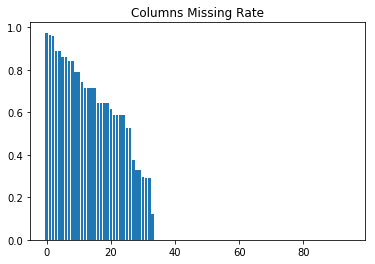

In [5]:
feature_process = BasicFeatureProcess()
# check constant variable
fixed_cols = feature_process.fix_value_check(train_data)
if fixed_cols:
    print('Constant columns:', fixed_cols)
    train_data = train_data.drop(fixed_cols, axis=1).copy()
else:
    print('No constant columns')
train_data.loc[train_data.age==0, 'age'] = np.nan
missing_rate_df = feature_process.missing_value_pct(train_data)
plt.bar(x=range(missing_rate_df.shape[0]), height=missing_rate_df['missing_rate'])
plt.title('Columns Missing Rate')

Text(0.5, 1.0, 'missing value odds ratio')

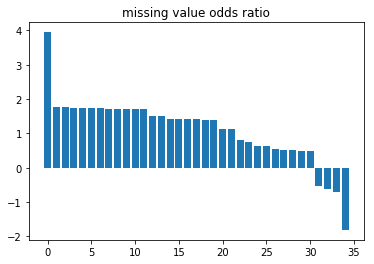

In [6]:
columns_with_missing = missing_rate_df.index[missing_rate_df.missing_rate>0].tolist()
train_data = feature_process.add_missing_indicator_to_df(data=train_data, cols=columns_with_missing)
missing_odds_ratio = feature_process.missing_odds_ratio(train_data, cols=columns_with_missing, flag_col='flag')
plt.bar(x=range(missing_odds_ratio.shape[0]), height=missing_odds_ratio.odds_ratio)
plt.title('missing value odds ratio')

In [7]:
obj_types = feature_process.feature_type_identifier(train_data, 'O')
obj_types

['registered_channels', 'area11_danger', 'area6_danger']

In [8]:
data_counts = train_data.nunique() 
categorical_cols = data_counts.index[data_counts<=10].tolist()
categorical_cols = list(set(categorical_cols+obj_types) - set(['flag']))

In [9]:
categoriacal_cols_with_missing = list(set(columns_with_missing) & set(categorical_cols))

In [10]:
dummy_result = feature_process.get_categorical_dummy_variable(train_data, categorical_cols)
train_data = dummy_result['data']
dummy_columns = dummy_result['dummy_cols']

In [11]:
continues_col_with_missing = list(set(columns_with_missing)-set(categoriacal_cols_with_missing))
train_data[continues_col_with_missing] = train_data[continues_col_with_missing].fillna(0)

In [12]:
feature_derive = FeatureDerivative()
train_data = feature_derive.avg_payment_derivative(train_data)
all_columns = list(train_data.columns)
all_columns.remove('ID')
all_columns.remove('flag')
numerical_columns = list(set(all_columns) - set(dummy_columns) - set(categorical_cols))
outlier_columns = get_outlier_features(train_data, numerical_columns, expand=True)

In [13]:
outlier_fraud_df = outlier_effect(train_data, outlier_cols=outlier_columns, flag_col='flag', expand=True)

D:\Codes\Python\FraudDetectProject\featureProcess\FeatureStandard.py:70: RuntimeWarning: divide by zero encountered in log
  lower_log_odds, upper_log_odds = np.log(l), np.log(u)


In [14]:
# no significant difference 
# feature standarlization
lower, upper, mu, sigma = {}, {}, {}, {}
for col in outlier_columns:
    temp_df = train_data[[col,'flag']]
    zero_score = zero_score_normalization(temp_df,col)
    if zero_score ==1:
        del train_data[col]
        numerical_columns.remove(col)
        continue
    train_data[col] = zero_score['new_var']
    lower[col], upper[col], mu[col], sigma[col] =zero_score['lower'], zero_score['upper'], zero_score['mu'], zero_score['sigma']

In [15]:
train_data.to_csv(folderOfData+'anti_fraud_data_cleaned.csv',index=False)

######### 集成方式1：Bagging ###########
<div>待选模型：LR， GBDT， DNN
<div>数据集准备：从原数据集中进行有放回地抽样形成某一个训练集，袋外数据用来进行参数选择

In [16]:
train_data['Idx'] = train_data.index
size = train_data.shape[0]
train_data2 = train_data.sample(n=size,replace=True)
trainDataIndex = set(list(train_data2.Idx))
OOB = train_data.loc[~train_data['Idx'].isin(list(trainDataIndex))]
OOB.shape[0]/train_data.shape[0]

0.3685378907675465

In [17]:
all_features = [feature for feature in list(train_data2.columns)]
all_features.remove('Idx')
all_features.remove('flag')

 ### Logistic Regression

In [19]:
C_list = np.arange(0.01,1,0.1)
auc = []
for c in C_list:
    LR = LogisticRegression(C=c).fit(train_data2[all_features], train_data2['flag'])
    pred = LR.predict_proba(OOB[all_features])[:,1]
    test_auc = roc_auc_score(OOB['flag'], pred)
    auc.append(test_auc)

position = auc.index(max(auc))
C_best = C_list[position]
print(max(auc))
LR = LogisticRegression(C=C_best).fit(train_data2[all_features], train_data2['flag'])
lr_pred = LR.predict_proba(train_data[all_features])[:,1]
lr_auc = roc_auc_score(train_data['flag'], lr_pred)    #0.917


C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

0.9111645994849661


C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
#GBDT
train_data2 = train_data.sample(n=size,replace=True)
trainDataIndex = set(list(train_data2.Idx))
OOB = train_data.loc[~train_data['Idx'].isin(list(trainDataIndex))]


best_max_depth = 8
best_min_samples_split, best_min_samples_leaf  = 70,5
best_max_features = 10
best_subsample = 0.7
best_n_estimators = 40


gbm_best = GradientBoostingClassifier(learning_rate=0.1, random_state=10,
                                      n_estimators=best_n_estimators,
                                      max_depth=best_max_depth,
                                      min_samples_leaf =best_min_samples_leaf,
                                      max_features=best_max_features,
                                      subsample =best_subsample)
gbm_best.fit(train_data2[all_features],train_data2['flag'])

gbdt_pred = gbm_best.predict_proba(train_data[all_features])[:,1]
gbdt_auc = roc_auc_score(train_data['flag'], gbdt_pred)   #0.995


In [21]:
gbdt_auc

0.9717736769522978

In [22]:
#ANN
train_data2 = train_data.sample(n=size, replace=True)
trainDataIndex = set(list(train_data2.Idx))
OOB = train_data.loc[~train_data['Idx'].isin(list(trainDataIndex))]
ann_clf = MLPClassifier(hidden_layer_sizes=(60,40,20))
ann_clf.fit(train_data2[all_features], train_data2['flag'])
ann_pred = ann_clf.predict_proba(train_data[all_features])[:,1]
ann_auc = roc_auc_score(train_data['flag'], ann_pred)    #0.958

In [23]:
ann_auc

0.7667285666731803

In [24]:
###### 模型的融合 ########
bagging_pred = pd.DataFrame({'LR':lr_pred, 'GBDT':gbdt_pred, 'ANN':ann_pred})
bagging_pred['avg_prob'] = bagging_pred.apply(np.mean, axis=1)
avg_auc = roc_auc_score(train_data['flag'], bagging_pred['avg_prob']) #0.995
avg_auc

0.9630558063125219

######### 集成方式2：Boosting ###########
#Adaboost 模型

In [25]:
bad = train_data[train_data.flag == 1]
good0 = train_data[train_data.flag == 0]
good = good0.iloc[:bad.shape[0]*10]
train_data_ada = pd.concat([bad, good])
param_test = {'n_estimators':range(5,101,5),'learning_rate':np.arange(0.1,1.1,0.1)}
gsearch = GridSearchCV(n_jobs=-1,estimator = AdaBoostClassifier(),
                        param_grid = param_test,iid=False,cv=5)
gsearch.fit(train_data_ada[all_features], train_data_ada['flag'])
best_n_estimators, best_learning_rate= gsearch.best_params_['n_estimators'],gsearch.best_params_['learning_rate']  #60,1

ada_clf = AdaBoostClassifier(n_estimators=best_n_estimators,learning_rate=best_learning_rate)
ada_clf.fit(train_data_ada[all_features], train_data_ada['flag'])
ada_pred = ada_clf.predict_proba(train_data[all_features])[:,1]
ada_auc = roc_auc_score(train_data['flag'], ada_pred)   #0.948


In [26]:
ada_auc

0.9579938723389292

In [27]:
######### 集成方式3：Stacking ###########
# Tier1 采用gbdt和ANN， Tier2 采用LR
idx = list(train_data.Idx)
K = 5
num_of_models = 2
gbdt_result = pd.DataFrame()
ann_result = pd.DataFrame()


In [28]:
#采用gbdt做Tier1中的第一个模型
#为了避免Tier1的子模型产生一定的相关性，构建交叉验证时将样本随机排列，使得Tier1的子模型的验证集拥有多样性
idx_shuffle = idx.copy()
shuffle(idx)
#使用K折交叉法，将数据集等分成K等分。又由于数据集的样本量未必是K的整倍数，因此第1~K-1份子集的大小是一致的，
# 第K份子集的大小不低于第1~K-1份子集的大小
sub_n = int(np.floor(len(idx_shuffle)/K))
interval_starts = [i*sub_n for i in range(K)]
interval_ends = [(i+1)*sub_n-1 for i in range(K-1)] + [len(idx_shuffle)-1]
for j in range(K):
    #拿出第j份子集作为验证集，其余的子集合并称为小训练集
    start_pot, end_pot = interval_starts[j],interval_ends[j]
    validation_idx = [idx_shuffle[m] for m in range(start_pot,end_pot+1)]
    validation_set = train_data.loc[train_data['Idx'].isin(validation_idx)]
    train_set = train_data.loc[~train_data['Idx'].isin(validation_idx)]
    #训练gbdt
    best_gbm = GradientBoostingClassifier(learning_rate=0.1, random_state=10,
                                      n_estimators=best_n_estimators,
                                      max_depth=best_max_depth,
                                      min_samples_leaf =best_min_samples_leaf,
                                      max_features=best_max_features,
                                      subsample =best_subsample)
    best_gbm.fit(train_set[all_features], train_set['flag'])
    gbdt_pred = best_gbm.predict_proba(validation_set[all_features])[:, 1]
    auc = roc_auc_score(validation_set['flag'], gbdt_pred)
    print("AUC is {}".format(auc))
    result_validation = pd.DataFrame({'Idx':validation_idx, 'gbdt_pred':gbdt_pred})
    gbdt_result = pd.concat([gbdt_result, result_validation])

AUC is 0.9564083965746826
AUC is 0.9170074601130415
AUC is 0.9344197645856964
AUC is 0.9214912859783471
AUC is 0.9368493452551869


In [42]:
#采用ANN做Tier1中的第二个模型。对数据集的预处理与GBDT时一样的。
shuffle(idx_shuffle)
sub_n = int(np.floor(len(idx_shuffle)/K))
interval_starts = [i*sub_n for i in range(K)]
interval_ends = [(i+1)*sub_n-1 for i in range(K-1)] + [len(idx_shuffle)-1]
for j in range(K):
    start_pot, end_pot = interval_starts[j],interval_ends[j]
    validation_idx = [idx_shuffle[m] for m in range(start_pot,end_pot+1)]
    validation_set = train_data.loc[train_data['Idx'].isin(validation_idx)]
    train_set = train_data.loc[~train_data['Idx'].isin(validation_idx)]
    #训练ann
    ann_clf = MLPClassifier(hidden_layer_sizes=(60, 40, 20))
    ann_clf.fit(train_set[all_features], train_set['flag'])
    ann_pred = ann_clf.predict_proba(validation_set[all_features])[:, 1]
    auc = roc_auc_score(validation_set['flag'], ann_pred)
    print("AUC is {}".format(auc))
    result_validation = pd.DataFrame({'Idx':validation_idx, 'ann_pred':ann_pred})
    ann_result = pd.concat([ann_result, result_validation])


AUC is 0.7299315852660605
AUC is 0.8583016194331985
AUC is 0.7848597651643338
AUC is 0.6804797612598484
AUC is 0.5089971472459952


In [44]:
tier1_pred = pd.merge(left=gbdt_result,right=ann_result, on='Idx', how='inner')
tier1_target = train_data[['Idx','flag']]
tier1_train = pd.merge(left=tier1_pred,right=tier1_target, on='Idx', how='inner')

LR2 = LogisticRegression().fit(tier1_train[['ann_pred','gbdt_pred']], tier1_train['flag'])
tier2_pred = LR2.predict_proba(tier1_train[['ann_pred','gbdt_pred']])[:,1]
roc_auc_score(tier1_train['flag'], tier2_pred)    #0.925

C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9275864232385972

## 测试集上做测试

In [30]:
# loading data
testing_data_clean = 'D:\\Codes\\Python\\FraudDetectProject\\data\\testing_data_clean.csv'
test_data = pd.read_csv(testing_data_clean)
print('overall fraud rate is {0:2.4f}%'.format(test_data['flag'].mean()*100))

overall fraud rate is 1.0643%


### bagging

In [32]:
# LR model
lr_pred = LR.predict_proba(test_data[all_features])[:,1]
lr_auc = roc_auc_score(test_data['flag'], lr_pred)   
lr_auc

C:\Users\Qian\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9094750430292599

In [34]:
gbdt_pred = gbm_best.predict_proba(test_data[all_features])[:,1]
gbdt_auc = roc_auc_score(test_data['flag'], gbdt_pred)   
gbdt_auc

0.9296600688468158

In [35]:
ann_pred = ann_clf.predict_proba(test_data[all_features])[:,1]
ann_auc = roc_auc_score(test_data['flag'], ann_pred)
ann_auc

0.7439376553834386

In [39]:
###### bagging模型的融合 ########
bagging_pred = pd.DataFrame({'LR':lr_pred, 'GBDT':gbdt_pred, 'ANN':ann_pred})
bagging_pred['avg_prob'] = bagging_pred.mean(axis=1)
avg_auc = roc_auc_score(test_data['flag'], bagging_pred['avg_prob']) #0.995
avg_auc

0.9138267355134826

### Boosting 
#Adaboost 模型

In [40]:
ada_pred = ada_clf.predict_proba(test_data[all_features])[:,1]
ada_auc = roc_auc_score(test_data['flag'], ada_pred)   
ada_auc

0.9287064926372155

###集成方式3：Stacking 
#### Tier1 采用gbdt和ANN， Tier2 采用LR

In [50]:
test_data['Idx'] = test_data.index
idx = list(test_data.Idx)
K = 5
num_of_models = 2
gbdt_result = pd.DataFrame()
ann_result = pd.DataFrame()

In [51]:
idx_shuffle = idx.copy()
shuffle(idx)

In [53]:
#gbdt做Tier1中的第一个模型
sub_n = int(np.floor(len(idx_shuffle)/K))
interval_starts = [i*sub_n for i in range(K)]
interval_ends = [(i+1)*sub_n-1 for i in range(K-1)] + [len(idx_shuffle)-1]
for j in range(K):
    start_pot, end_pot = interval_starts[j],interval_ends[j]
    validation_idx = [idx_shuffle[m] for m in range(start_pot,end_pot+1)]
    validation_set = test_data.loc[test_data['Idx'].isin(validation_idx)]
    gbdt_pred = best_gbm.predict_proba(validation_set[all_features])[:, 1]
    auc = roc_auc_score(validation_set['flag'], gbdt_pred)
    print("AUC is {}".format(auc))
    result_validation = pd.DataFrame({'Idx':validation_idx, 'gbdt_pred':gbdt_pred})
    gbdt_result = pd.concat([gbdt_result, result_validation])

AUC is 0.9679392757142666
AUC is 0.989688554790371
AUC is 0.9173840267814444
AUC is 0.975659229208925
AUC is 0.9624880611270297


In [57]:
#ANN做Tier1中的第二个模型
shuffle(idx_shuffle)
sub_n = int(np.floor(len(idx_shuffle)/K))
interval_starts = [i*sub_n for i in range(K)]
interval_ends = [(i+1)*sub_n-1 for i in range(K-1)] + [len(idx_shuffle)-1]
for j in range(K):
    start_pot, end_pot = interval_starts[j],interval_ends[j]
    validation_idx = [idx_shuffle[m] for m in range(start_pot,end_pot+1)]
    validation_set = test_data.loc[test_data['Idx'].isin(validation_idx)]
    test_set = test_data.loc[~test_data['Idx'].isin(validation_idx)]
    #训练ann
    ann_clf = MLPClassifier(hidden_layer_sizes=(60, 40, 20))
    ann_clf.fit(test_set[all_features], test_set['flag'])
    ann_pred = ann_clf.predict_proba(validation_set[all_features])[:, 1]
    auc = roc_auc_score(validation_set['flag'], ann_pred)
    print("AUC is {}".format(auc))
    result_validation = pd.DataFrame({'Idx':validation_idx, 'ann_pred':ann_pred})
    ann_result = pd.concat([ann_result, result_validation])

AUC is 0.46476252652195205
AUC is 0.40965006568732826
AUC is 0.6571519566861737
AUC is 0.42445482866043616
AUC is 0.5361558338302523


In [58]:
tier1_pred = pd.merge(left=gbdt_result,right=ann_result, on='Idx', how='inner')
tier1_target = test_data[['Idx','flag']]
tier1_test = pd.merge(left=tier1_pred,right=tier1_target, on='Idx', how='inner')

# LR = LogisticRegression().fit(tier1_test[['ann_pred','gbdt_pred']], tier1_train['flag'])
tier2_pred = LR2.predict_proba(tier1_test[['ann_pred','gbdt_pred']])[:,1]
roc_auc_score(tier1_test['flag'], tier2_pred)    #0.925

0.9600102792120864